<a href="https://colab.research.google.com/github/hot-temper/Academic_ML/blob/main/multiclass_classification_accuracy_92_69.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import shutil
import random
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.model_selection import train_test_split , learning_curve , GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , RobustScaler , PolynomialFeatures , MinMaxScaler , label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , f1_score , roc_curve , roc_auc_score , precision_recall_curve , average_precision_score , roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier , AdaBoostClassifier , StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer , make_column_selector
from sklearn.feature_selection import SelectKBest, f_classif

In [4]:
path='/content/earthquake_alert_balanced_dataset.csv'

data = pd.read_csv(path)

# Exploration et analyse des données ( EDA )

# Analyse de la forme


In [5]:
earthquake = data.copy()

In [6]:
earthquake.head()

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


In [7]:
earthquake.shape

(1300, 6)

In [8]:
earthquake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1300 non-null   float64
 1   depth      1300 non-null   float64
 2   cdi        1300 non-null   float64
 3   mmi        1300 non-null   float64
 4   sig        1300 non-null   float64
 5   alert      1300 non-null   object 
dtypes: float64(5), object(1)
memory usage: 61.1+ KB


In [9]:
earthquake.dtypes

,0
magnitude,float64
depth,float64
cdi,float64
mmi,float64
sig,float64
alert,object


In [10]:
earthquake.columns

Index(['magnitude', 'depth', 'cdi', 'mmi', 'sig', 'alert'], dtype='object')

In [11]:
earthquake.isna().sum()

,0
magnitude,0
depth,0
cdi,0
mmi,0
sig,0
alert,0


In [12]:
earthquake.describe()

,magnitude,depth,cdi,mmi,sig
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.061008,50.321538,6.976154,6.939231,-9.749231
std,0.423738,104.348286,2.244875,1.354774,62.245214
min,6.500000,2.000000,0.000000,1.000000,-128.000000
25%,6.700000,12.000000,6.000000,6.000000,-54.000000
50%,7.000000,19.000000,8.000000,7.000000,-7.000000
75%,7.300000,38.000000,8.000000,8.000000,31.000000
max,8.600000,670.000000,9.000000,9.000000,127.000000


In [13]:
def detect_outilers(df , v) :

    Q1 = df[v].quantile(0.25)
    Q3 = df[v].quantile(0.75)
    IQR = Q3 - Q1

    # Définir les bornes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Sélectionner les valeurs aberrantes
    outliers = df[(df[v] < lower_bound) | (df[v] > upper_bound)]
    return outliers.shape[0]

In [14]:
for v in earthquake.select_dtypes('float') :
    print(f"Nombre d'outliers de la varible {v} : {detect_outilers(earthquake , v)}")

Nombre d'outliers de la varible magnitude : 13
Nombre d'outliers de la varible depth : 168
Nombre d'outliers de la varible cdi : 88
Nombre d'outliers de la varible mmi : 5
Nombre d'outliers de la varible sig : 0


# Résultats


**Varaibles explicatives :** magnitude, depth, cdi, mmi, sig

**Varaible Target :** alert

**Nombre de lignes et colonnes** : (1300, 6)

**Type de variables** Toutes les variables significatives sont de type **float64**

# Analyse de fond

## Analyse de la target :

<Axes: xlabel='alert'>

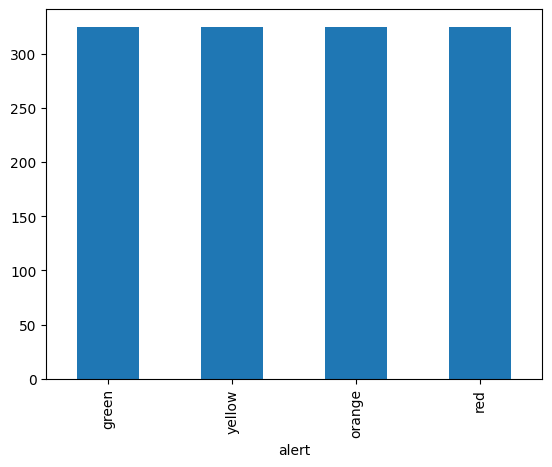

In [15]:
earthquake['alert'].value_counts().plot.bar()

**Conclusion** : Dataset equilibré

## Analyse des variables explicatives :

## 1) Variables quantitatives :

<Figure size 640x480 with 0 Axes>

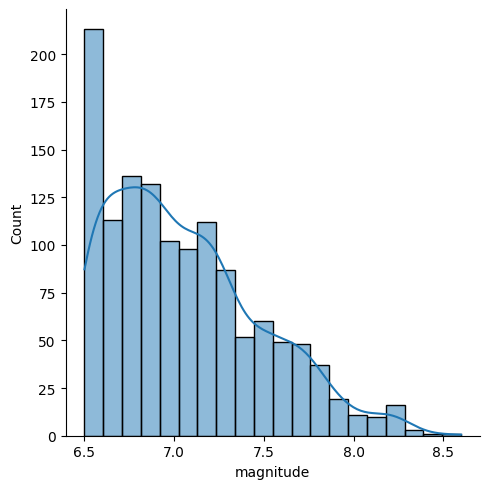

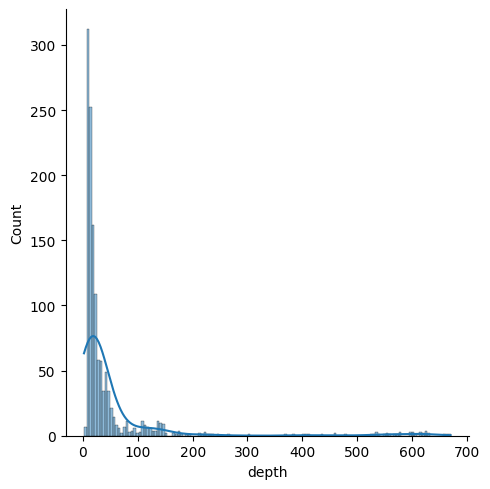

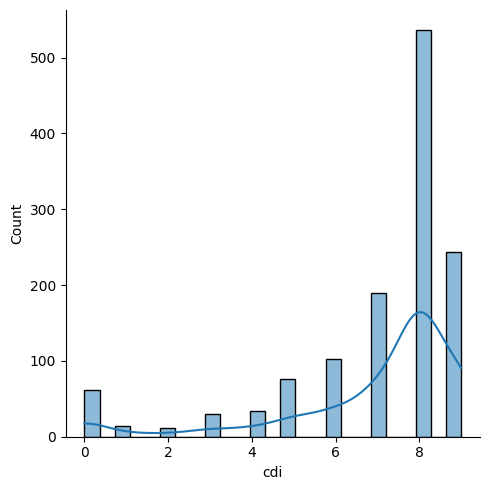

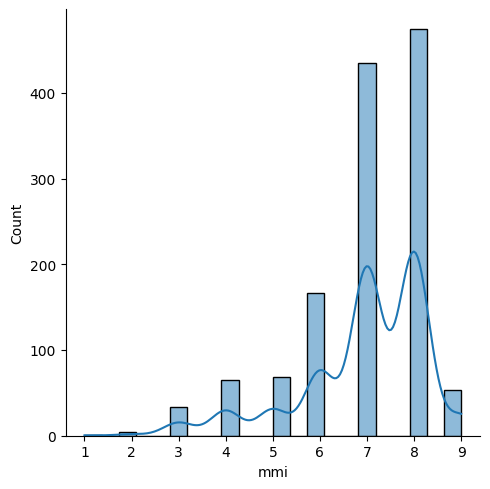

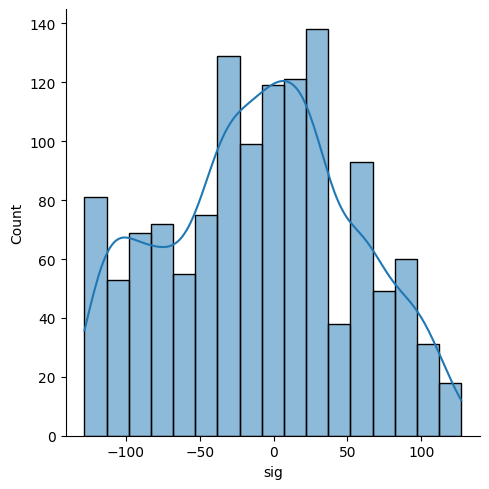

In [16]:
plt.figure()
for col in earthquake.select_dtypes('float') :
    sns.displot(x=col ,data=earthquake, kde=True)

## 3) Relation entre variables / Target :

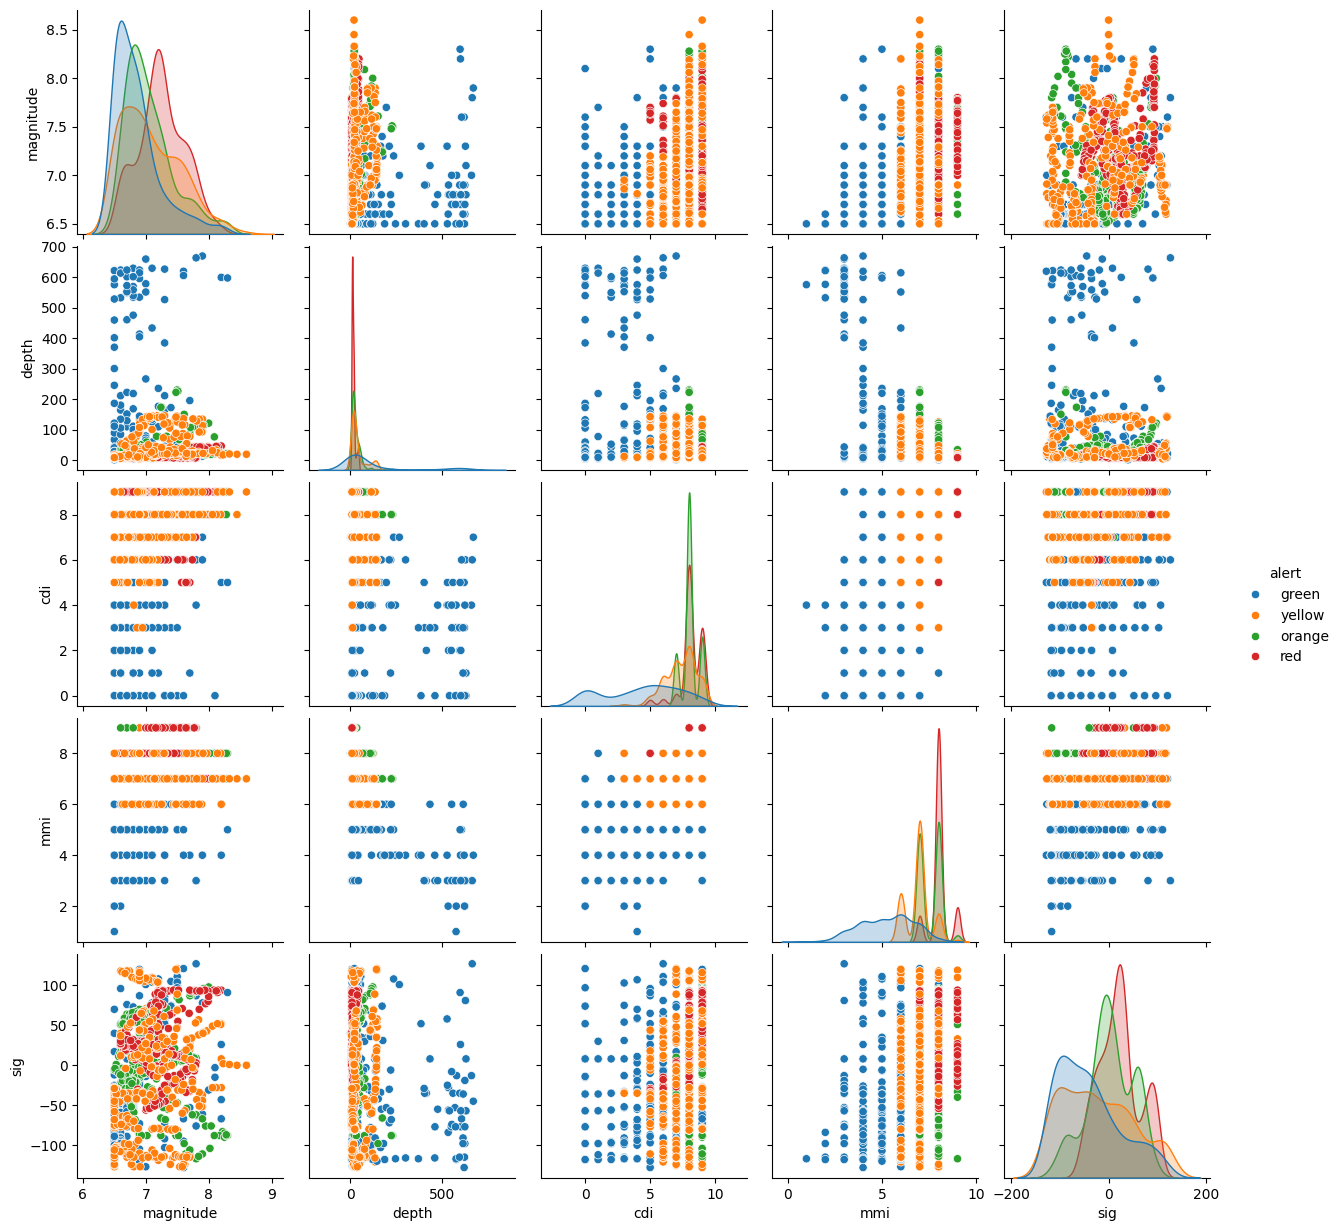

In [17]:
sns.pairplot(data=earthquake, hue='alert')

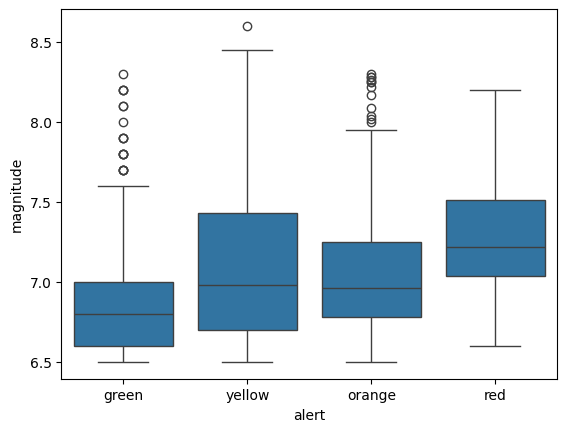

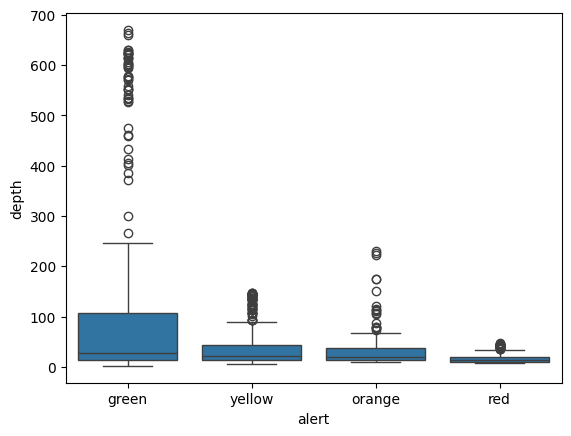

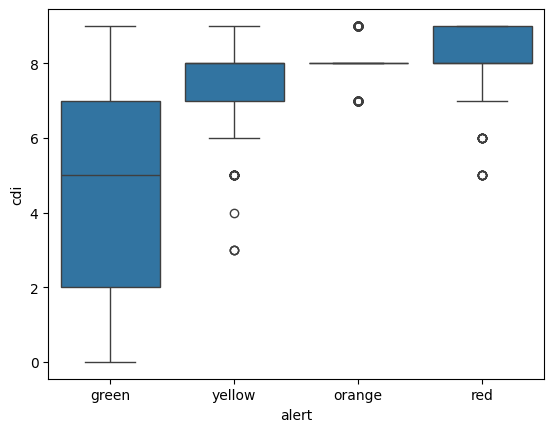

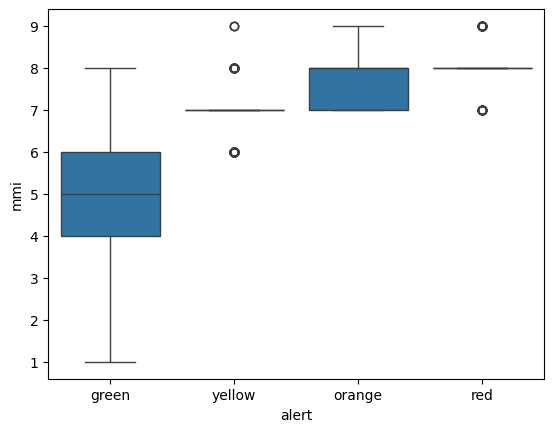

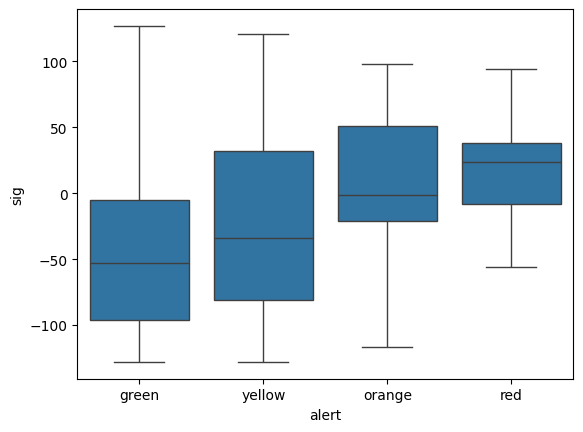

In [18]:
for v in earthquake.select_dtypes('float') :
  plt.figure()
  sns.boxplot(x='alert', y=v, data=earthquake)

## 4) Analyse plus détaillée :

<Axes: >

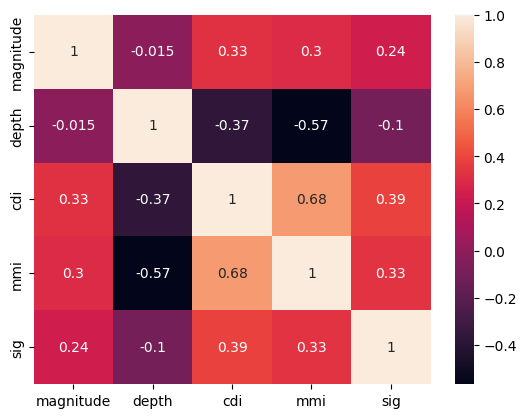

In [19]:
sns.heatmap(earthquake[earthquake.select_dtypes('float').columns].corr() , annot=True)

Pas de corrélation entre les variables

In [20]:
from scipy import stats

# Boucle sur toutes les variables quantitatives
for col in earthquake.select_dtypes('float'):
    # Grouper les données par niveau d'alerte
    groups = [group[col].values for name, group in earthquake.groupby('alert')]

    # Test ANOVA
    f_stat, p = stats.f_oneway(*groups)

    if p < 0.005:
        print(f"Dépendance entre {col} et alert  (p-value={p:.5f})")
    else:
        print(f"Indépendance entre {col} et alert  (p-value={p:.5f})")


Dépendance entre magnitude et alert  (p-value=0.00000)
Dépendance entre depth et alert  (p-value=0.00000)
Dépendance entre cdi et alert  (p-value=0.00000)
Dépendance entre mmi et alert  (p-value=0.00000)
Dépendance entre sig et alert  (p-value=0.00000)


# Data preprocessing :

In [21]:
encodage = {'green': 0, 'yellow': 1, 'orange': 2, 'red': 3}
earthquake['alert'] = earthquake['alert'].map(encodage)

In [22]:
X = earthquake.drop('alert' , axis=1)
y = earthquake['alert']

In [23]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42 , stratify=y)

# Developpement du modèle et optimisation

## 1) Pipeline de Preprocessing

In [24]:
encoder = make_pipeline(PolynomialFeatures(degree=2,include_bias=False) , RobustScaler()) # pré-traiter les données numériques

In [25]:
# model = make_pipeline(preprocesseur , SelectKBest(score_func=f_classif, k=12) , DecisionTreeClassifier(random_state=0))

In [26]:
scaler = RobustScaler()

In [27]:
from xgboost import XGBClassifier

In [28]:
models = {'LogisticRegression' : LogisticRegression(random_state=0 , max_iter=1000) ,
          'KNN' : KNeighborsClassifier() ,
          'SVC' : SVC(random_state=0) ,
          'DecisionTree' : DecisionTreeClassifier(random_state=0) ,
          'RandomForest' : RandomForestClassifier(random_state=0) ,
          'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0)
         }

In [29]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, scoring='accuracy'):
    # Entraînement
    model.fit(X_train, y_train)

    # Courbe d'apprentissage
    print("*************** Courbe d'apprentissage *******************")
    N, train_score, test_score = learning_curve(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1, 10)
    )

    plt.figure(figsize=(6, 4))
    plt.plot(N, train_score.mean(axis=1), label='Train score')
    plt.plot(N, test_score.mean(axis=1), label='Test score')
    plt.xlabel("Taille d'échantillon d'entraînement")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.title("Courbe d'apprentissage")
    plt.show()

    # Évaluation
    print("*************** Évaluation du modèle *******************")
    y_pred = model.predict(X_test)

    print("Accuracy sur le test:", accuracy_score(y_test, y_pred))
    print("Classification Report :\n", classification_report(y_test, y_pred))

    print("Matrice de confusion :")
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.title("Matrice de confusion")
    plt.show()

    # ROC + PR pour les modèles qui supportent predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)

        # Binariser les labels si multi-classes
        classes = np.unique(y_test)
        if len(classes) > 2:
            y_test_bin = label_binarize(y_test, classes=classes)

            # ROC et AUC pour chaque classe
            plt.figure(figsize=(6, 4))
            for i, class_name in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title("Courbes ROC multi-classes")
            plt.legend()
            plt.show()
        else:
            # Binaire
            y_proba_bin = y_proba[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba_bin)
            roc_auc_score_val = roc_auc_score(y_test, y_proba_bin)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_score_val:.2f})")
            plt.plot([0, 1], [0, 1], "k--")
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title("Courbe ROC")
            plt.legend()
            plt.show()

        # Precision-Recall
        if len(classes) > 2:
            plt.figure(figsize=(6, 4))
            for i, class_name in enumerate(classes):
                precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
                ap = average_precision_score(y_test_bin[:, i], y_proba[:, i])
                plt.plot(recall, precision, label=f'{class_name} (AP={ap:.2f})')
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Courbes Precision-Recall multi-classes")
            plt.legend()
            plt.show()
        else:
            precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
            ap = average_precision_score(y_test, y_proba[:, 1])
            plt.figure(figsize=(6, 4))
            plt.plot(recall, precision, label=f"PR (AP = {ap:.2f})")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Courbe Precision-Recall")
            plt.legend()
            plt.show()

    else:
        print("⚠️ Ce modèle ne supporte pas predict_proba, ROC/AUC et PR ne peuvent pas être tracés.")


LogisticRegression
*************** Courbe d'apprentissage *******************


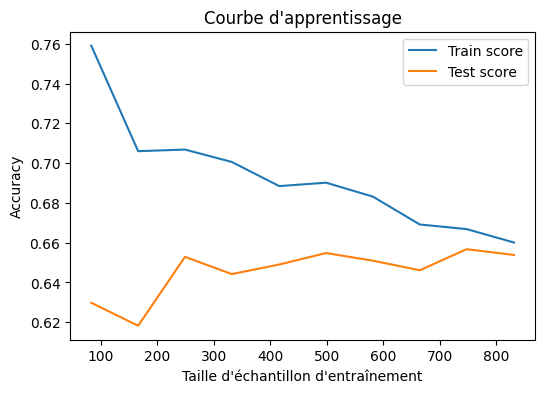

*************** Évaluation du modèle *******************
Accuracy sur le test: 0.6384615384615384
Classification Report :
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        65
           1       0.45      0.51      0.48        65
           2       0.59      0.45      0.51        65
           3       0.73      0.82      0.77        65

    accuracy                           0.64       260
   macro avg       0.64      0.64      0.63       260
weighted avg       0.64      0.64      0.63       260

Matrice de confusion :


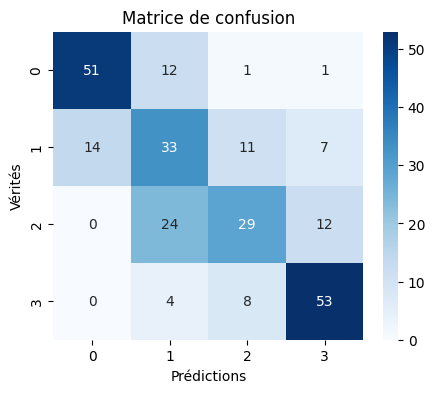

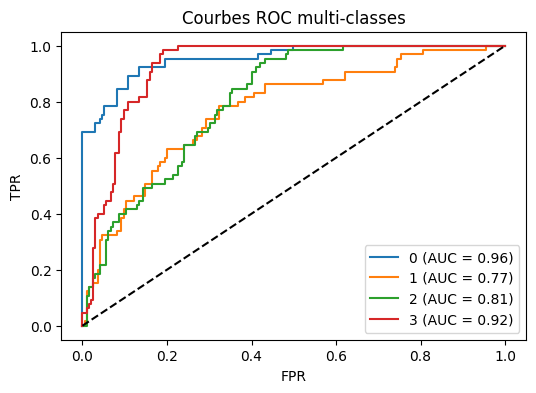

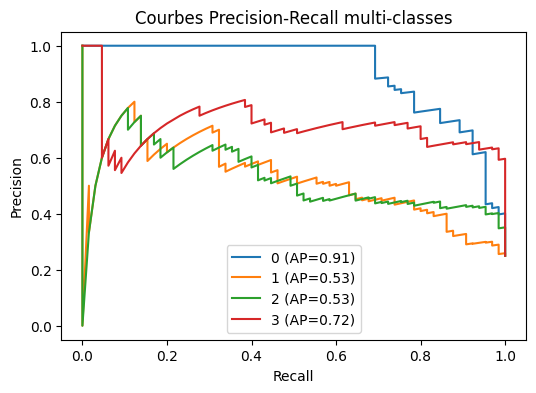

KNN
*************** Courbe d'apprentissage *******************


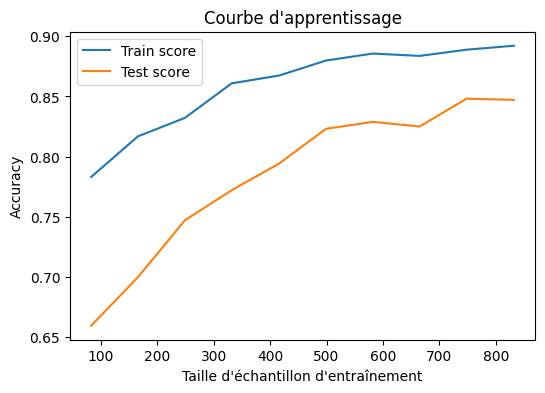

*************** Évaluation du modèle *******************
Accuracy sur le test: 0.8692307692307693
Classification Report :
               precision    recall  f1-score   support

           0       0.96      0.74      0.83        65
           1       0.79      0.86      0.82        65
           2       0.86      0.91      0.88        65
           3       0.90      0.97      0.93        65

    accuracy                           0.87       260
   macro avg       0.88      0.87      0.87       260
weighted avg       0.88      0.87      0.87       260

Matrice de confusion :


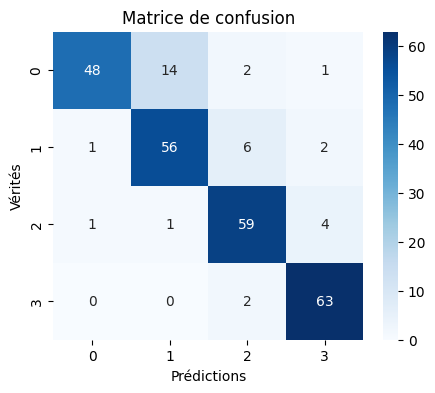

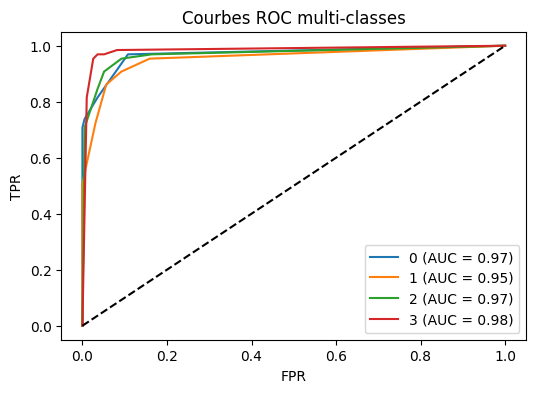

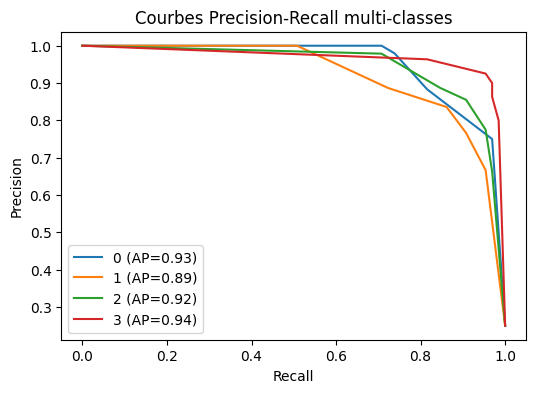

SVC
*************** Courbe d'apprentissage *******************


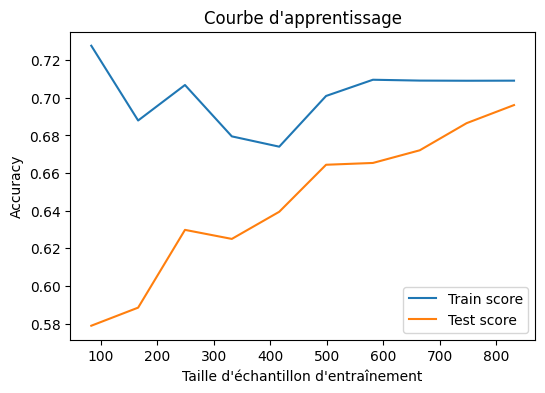

*************** Évaluation du modèle *******************
Accuracy sur le test: 0.6923076923076923
Classification Report :
               precision    recall  f1-score   support

           0       0.88      0.77      0.82        65
           1       0.54      0.58      0.56        65
           2       0.68      0.65      0.66        65
           3       0.71      0.77      0.74        65

    accuracy                           0.69       260
   macro avg       0.70      0.69      0.70       260
weighted avg       0.70      0.69      0.70       260

Matrice de confusion :


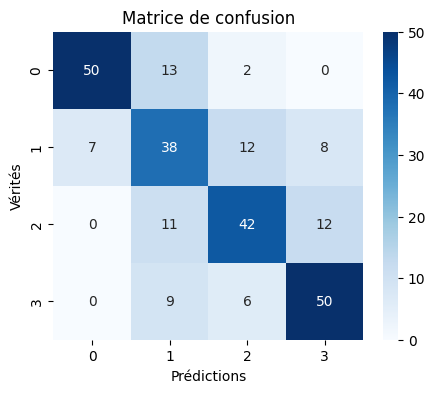

⚠️ Ce modèle ne supporte pas predict_proba, ROC/AUC et PR ne peuvent pas être tracés.
DecisionTree
*************** Courbe d'apprentissage *******************


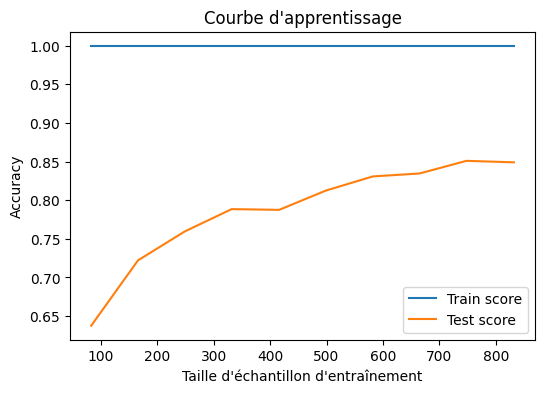

*************** Évaluation du modèle *******************
Accuracy sur le test: 0.8307692307692308
Classification Report :
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        65
           1       0.80      0.78      0.79        65
           2       0.81      0.83      0.82        65
           3       0.86      0.92      0.89        65

    accuracy                           0.83       260
   macro avg       0.83      0.83      0.83       260
weighted avg       0.83      0.83      0.83       260

Matrice de confusion :


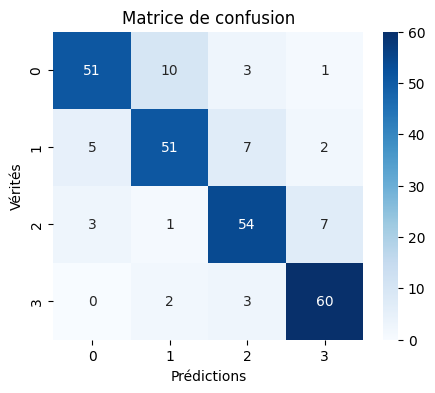

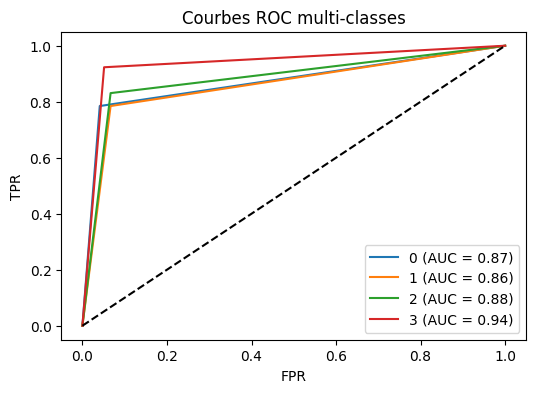

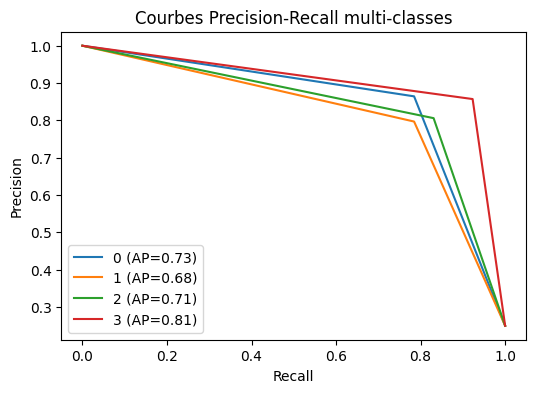

RandomForest
*************** Courbe d'apprentissage *******************


In [ ]:
for name,  model in models.items() :
    print(name)
    estimator = make_pipeline(RobustScaler() , model)
    train_and_evaluate(estimator, X_train, y_train, X_test, y_test, scoring='accuracy')

### Classement des modèles :

1) XGBoost

2) RandomForest

3) KNN

In [ ]:
Bagging_KNN  = BaggingClassifier(KNeighborsClassifier() , n_estimators=50)
model = make_pipeline(RobustScaler() , Bagging_KNN)
train_and_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0)
train_and_evaluate(model, X_train, y_train, X_test, y_test)

### Classement des modèles (Avec Bagging ) :

1) XGBoost ( 0.91 )

2) RandomForest ( 0.9 )

3) KNN (0.88)

In [ ]:
model1 = make_pipeline(RobustScaler() , XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0))
model2 = make_pipeline(RobustScaler() , RandomForestClassifier(random_state=0))
model3 = make_pipeline(RobustScaler() , Bagging_KNN)

In [ ]:
for model in (model1 , model2 , model3) :
    train_and_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
base_models = [('XGB', model1),('RandomForest', model2),('Bagging_KNN' , model3)]

stacking = StackingClassifier(estimators=base_models,final_estimator=LogisticRegression(random_state=0) ,  cv=5)

In [ ]:
train_and_evaluate(stacking, X_train, y_train, X_test, y_test)

### Modèle choisi : stacking

In [ ]:
stacking

In [ ]:
final_model = stacking

In [ ]:
train_and_evaluate(final_model, X_train, y_train, X_test, y_test)

In [ ]:
import joblib

joblib.dump(final_model, "/kaggle/working/earthquake_model.joblib")

In [ ]:
final_model = joblib.load("/kaggle/working/earthquake_model.joblib")

In [ ]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test , y_pred))
print(accuracy_score(y_test , y_pred))

In [ ]:
                                                          #################################################################### FIN ########################################################################